In [64]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [86]:
credit = pd.read_excel("Data Set.xlsx")

In [66]:
credit_x = pd.read_excel("Data Set.xlsx")

In [67]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 130 entries, custid to response_03
dtypes: float64(31), int64(97), object(2)
memory usage: 5.0+ MB


In [68]:
credit.isna().sum()

custid            0
region            0
townsize          2
gender            0
age               0
agecat            0
birthmonth        0
ed                0
edcat             0
jobcat            0
union             0
employ            0
empcat            0
retire            0
income            0
lninc             0
inccat            0
debtinc           0
creddebt          0
lncreddebt        1
othdebt           0
lnothdebt         1
default           0
jobsat            0
marital           0
spoused           0
spousedcat        0
reside            0
pets              0
pets_cats         0
               ... 
cardten           2
lncardten      1422
wireless          0
wiremon           0
lnwiremon      3656
wireten           0
lnwireten      3656
multline          0
voice             0
pager             0
internet          0
callid            0
callwait          0
forward           0
confer            0
ebill             0
owntv             0
hourstv           0
ownvcr            0


In [87]:
# Deleting the log form of each feild as it have lots of null value
credit.drop(['lninc',
 'lncreddebt',
 'lnothdebt',
 'lnlongmon',
 'lnlongten',
 'lntollmon',
 'lntollten',
 'lnequipmon',
 'lnequipten',
 'lncardmon',
 'lncardten',
 'lnwiremon',
 'lnwireten'],axis=1,inplace=True)

In [70]:
credit.isnull().sum().sum()

9

In [99]:
credit['carown'].value_counts()

1    3700
0    1295
Name: carown, dtype: int64

In [89]:
# for these feild -1 has no significance that's why i am replacig it with 0
credit['carown'].replace(-1,0,inplace= True)

In [90]:
credit['cartype'].replace(-1,0,inplace= True)

In [91]:
credit['carvalue'].replace(-1,0,inplace= True)

In [92]:
credit['carcatvalue'].replace(-1,0,inplace= True)

In [93]:
credit['carbought'].replace(-1,0,inplace= True)

In [94]:
# These 2 variables has no significance 
credit.drop(['custid','birthmonth'],axis=1,inplace = True)

In [95]:
# making the dependent variable
credit['Total']=credit['cardspent']+credit['card2spent']
credit.drop(['cardspent','card2spent'],axis=1,inplace = True)

In [96]:
# replace -1 to 0 as 0 denotes uneducated
credit['spousedcat'].replace(-1,0,inplace=True)
credit['spoused'].replace(-1,0,inplace=True)

In [97]:
credit.dropna(inplace=True)

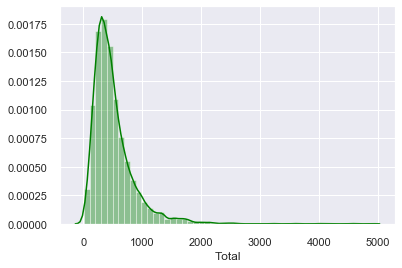

In [98]:
sns.distplot(credit['Total'],color='Green')

In [100]:
credit.shape

(4995, 114)

In [101]:
credit.dropna(inplace=True)

In [102]:
categorical=['region','townsize','gender','agecat','edcat','jobcat','union','employ','empcat','retire','inccat',
         'default','jobsat','marital','spousedcat','homeown','hometype','address','addresscat','cars','carown','cartype',
         'carcatvalue','carbought','carbuy','commute','commutecat','commutecar','commutemotorcycle','commutecarpool',
         'commutebus','commuterail','commutepublic','commutebike','commutewalk','commutenonmotor','telecommute','reason',
         'polview','polparty','polcontrib','vote','card','cardtype','cardbenefit','cardfee','cardtenure','cardtenurecat',
         'card2','card2type','card2benefit','card2fee','card2tenure','card2tenurecat','active','bfast','churn','tollfree',
         'equip','callcard','wireless','multline','voice','pager','internet','callid','callwait','forward','confer','ebill',
         'owntv','ownvcr','owndvd','owncd','ownpda','ownpc','ownipod','owngame','ownfax','news','response_01','response_02',
         'response_03']


In [103]:
len(categorical)

83

In [104]:
# Numerical List= Contains numerical variables..
numerical=[]
for var in credit.columns:
    if var not in categorical:
        numerical.append(var)

In [105]:
# Creating a seperate dataframe named credit_categorical for categorical variables.
credit_categorical = pd.DataFrame()
for i in credit.columns.values:
      if i in categorical:
        credit_categorical[i]=credit[i]

In [106]:
#creating a seperate dataframe named credit_numerical for numerical variables.
credit_numerical = pd.DataFrame()
for i in credit.columns.values:
      if i in numerical:
        credit_numerical[i]=credit[i]

In [107]:
# credit_numerical.drop(labels=(['custid', 'birthmonth']),
#     axis=1, inplace=True)

In [108]:
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df
# Missing value imputation for continuous variables.
def missing_imputation_continuous(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    return x


In [109]:
credit_categorical.shape

(4995, 83)

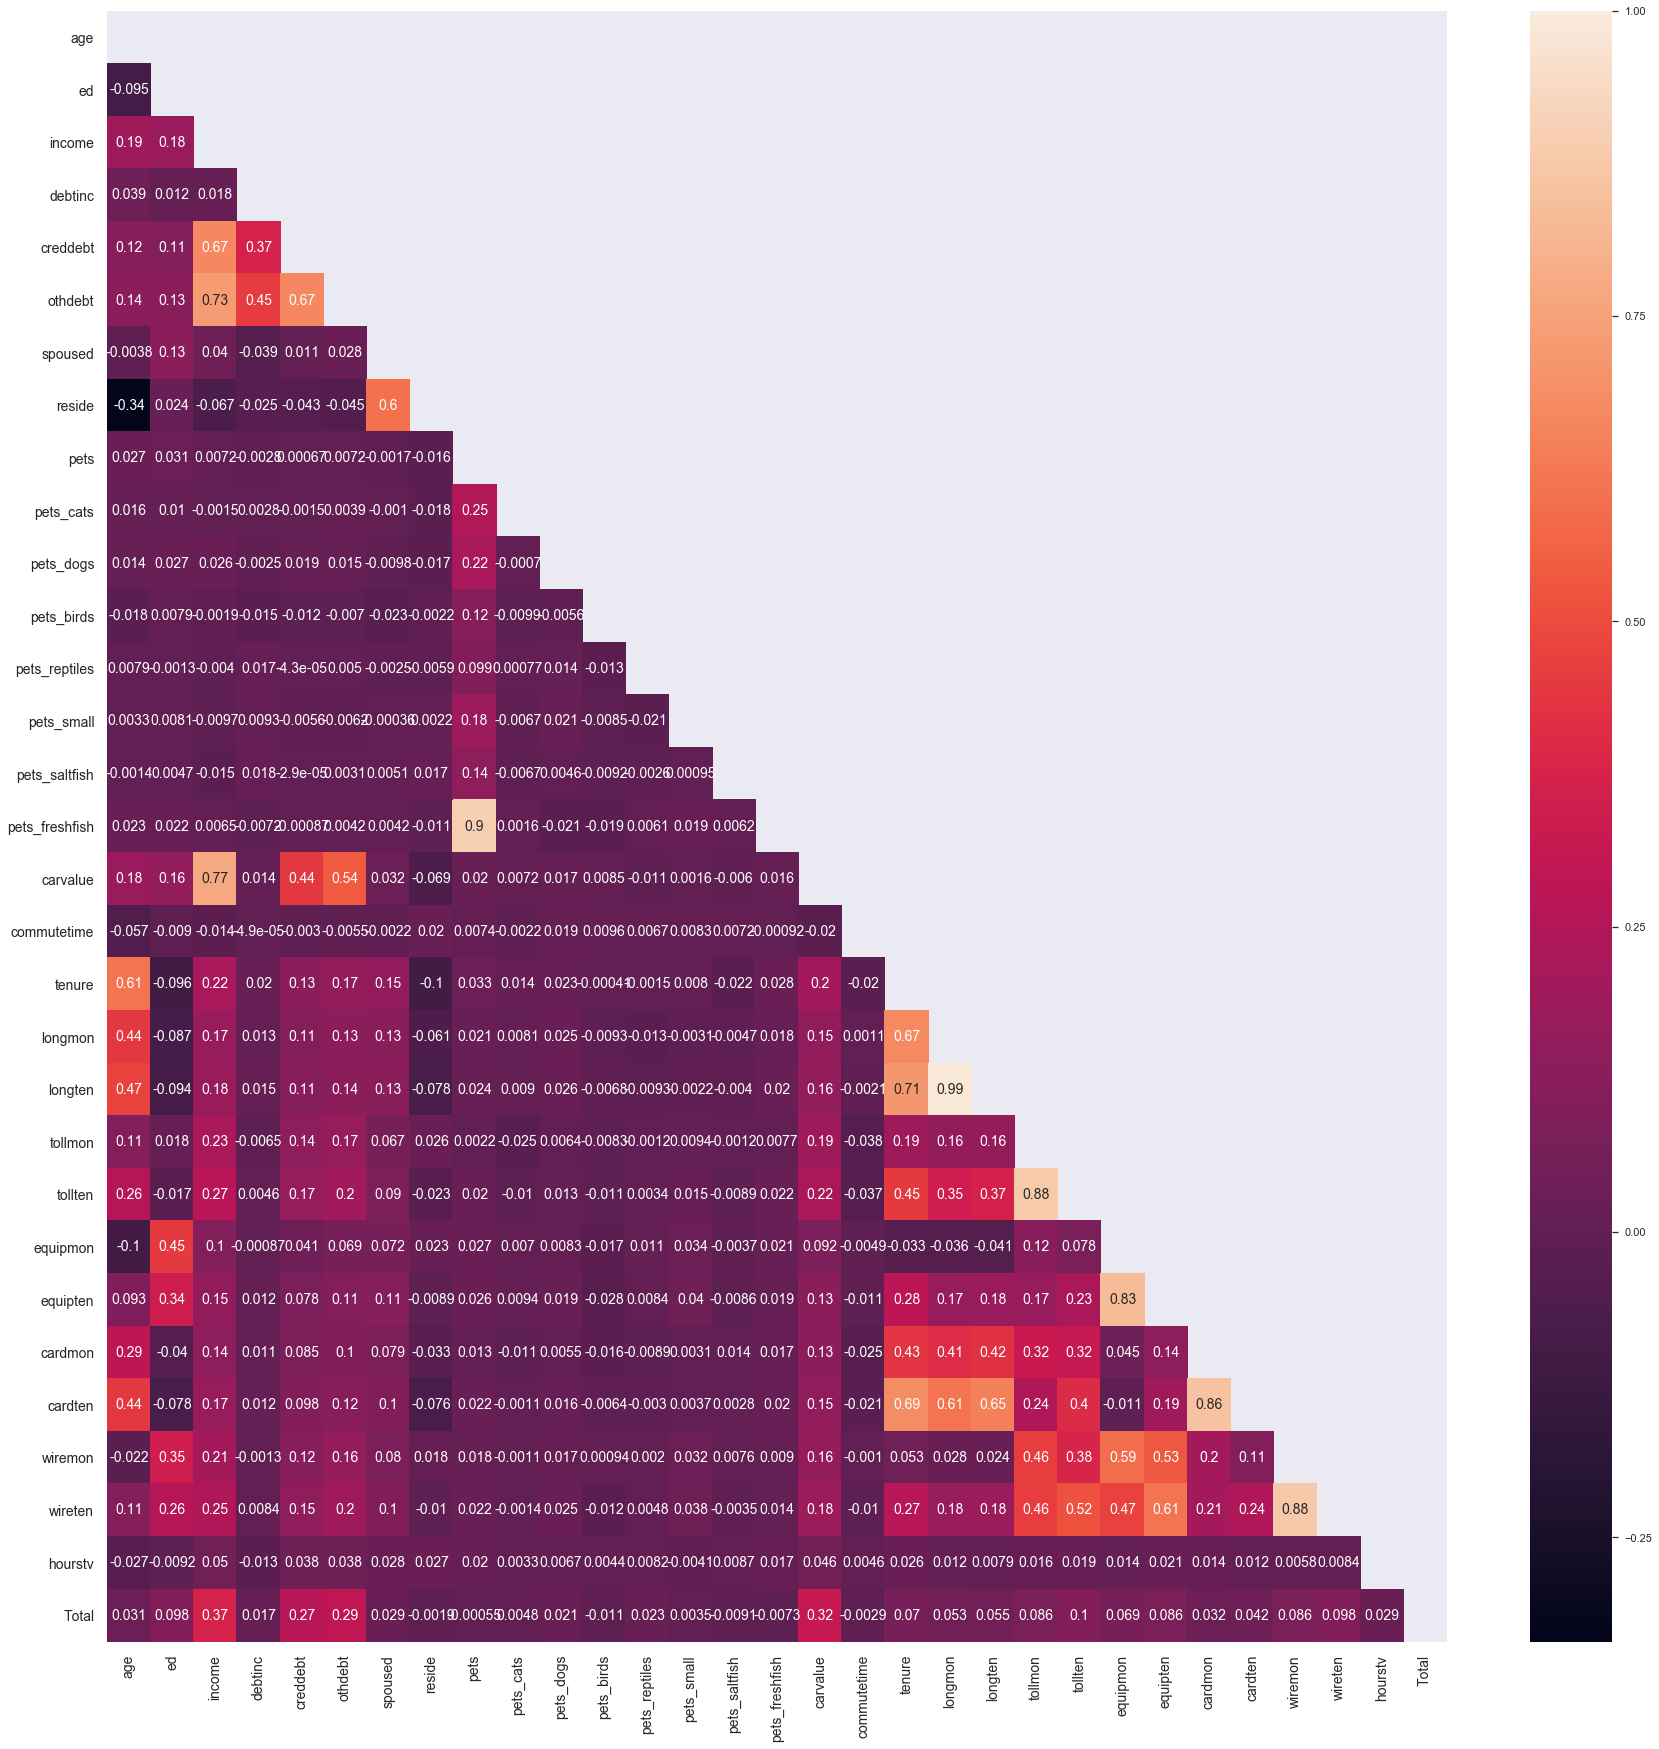

In [110]:
mask = np.zeros_like(credit_numerical.corr())
triangle_indices = np.triu_indices_from(mask)
mask[triangle_indices] = True

plt.figure(figsize=(30,30))
sns.heatmap(credit_numerical.corr(), mask=mask, annot=True, annot_kws={"size": 14})
sns.set_style('white')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [111]:
variables = credit_numerical[credit_numerical.columns.difference(['Total'])]

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
vif

C:\Users\acer\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF,features
0,13.387130,age
1,13.292682,cardmon
2,15.223353,cardten
3,5.703636,carvalue
4,15.304659,commutetime
5,3.115516,creddebt
6,6.555009,debtinc
7,20.382440,ed
8,10.232422,equipmon
9,9.061528,equipten


In [112]:
credit_numerical
credit_numerical = credit_numerical.apply(lambda x: x.clip(lower = x.dropna().quantile(0.01), upper = x.quantile(0.99)))

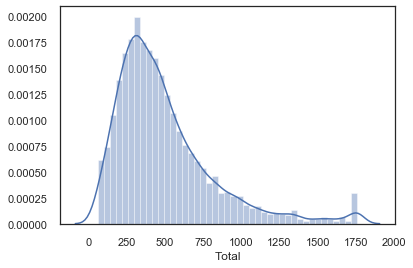

In [113]:
sns.distplot(credit_numerical['Total'])

In [114]:
credit_categorical['townsize'].astype('int')

0       2
1       5
2       4
3       3
4       2
5       4
6       5
7       4
8       3
9       2
10      1
11      4
12      2
13      2
14      1
15      1
16      1
17      2
18      5
19      1
20      3
21      4
22      1
23      4
24      3
25      3
26      4
27      1
28      1
29      3
       ..
4970    2
4971    5
4972    1
4973    5
4974    3
4975    4
4976    1
4977    5
4978    1
4979    1
4980    1
4981    1
4982    3
4983    2
4984    3
4985    2
4986    1
4987    4
4988    2
4989    2
4990    3
4991    2
4992    4
4993    3
4994    1
4995    2
4996    3
4997    5
4998    1
4999    5
Name: townsize, Length: 4995, dtype: int32

In [115]:
def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname)
    col_dummies.drop(col_dummies.columns[0], axis=1, inplace=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

In [116]:
# df_dummy =credit_categorical
# df_dummy
for dm in categorical:
    credit_categorical = create_dummies(credit_categorical,dm)



In [117]:
credit_categorical.shape

(4995, 342)

In [263]:
credit_new = pd.concat([credit_numerical, credit_categorical], axis = 1)

In [264]:
credit_new.shape

(4995, 373)

In [120]:
credit_new['total_log']=np.log(credit['Total'])

In [121]:
credit_new.drop('Total',axis=1,inplace= True)

In [254]:
credit_new.shape

(4995, 373)

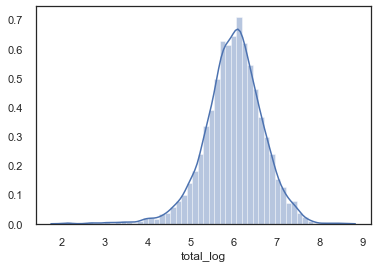

In [122]:
sns.distplot(credit_new['total_log'])

## Feature selection 

In [346]:
variables = credit_new[credit_new.columns.difference(['total_log'])]

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
vif

C:\Users\acer\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF,features
0,5.34,Total
1,2.24,active_1
2,2.52,address_1
3,inf,address_10
4,inf,address_11
5,inf,address_12
6,inf,address_13
7,inf,address_14
8,inf,address_15
9,inf,address_16


In [347]:
credit_analysis=credit_new.drop(list(vif[vif['VIF']>10]['features']),axis=1,inplace = False)

In [362]:
credit_analysis.shape
#credit_analysis['total_log']=np.log(credit['Total'])

(4995, 115)

In [351]:
x1 = credit_analysis.drop('total_log',axis=1)
y1 = credit_analysis['total_log']

In [358]:
train_x,test_x,train_y,test_y=train_test_split(x1,
                                               y1,test_size=0.2,
                                              random_state=15)

In [359]:
import statsmodels.api as sm
train_x = sm.add_constant(train_x)
test_x = sm.add_constant(test_x)
smlr = sm.OLS(train_y, train_x).fit()

In [360]:
smlr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              total_log   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     149.1
Date:                Fri, 13 Mar 2020   Prob (F-statistic):               0.00
Time:                        14:38:37   Log-Likelihood:                -717.69
No. Observations:                3996   AIC:                             1665.
Df Residuals:                    3881   BIC:                             2389.
Df Model:                         114                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   5.1795      0.043    119.472      0.000       5.094       5.264
creddebt                0.0007      0.003      0.242      0.809      -0.005       0.006
othdebt                 0.0022      0.002      1.433      0.152      -0.001       0.005
reside                  0.0016      0.004      0.422      0.673      -0.006       0.009
pets_dogs              -0.0102      0.006     -1.666      0.096      -0.022       0.002
pets_birds             -0.0053      0.010     -0.539      0.590      -0.025       0.014
pets_reptiles          -0.0099      0.017     -0.594      0.553      -0.043       0.023
pets_small             -0.0150      0.010     -1.526      0.127      -0.034       0.004
pets_saltfish           0.0328      0.023      1.431      0.152      -0.012       0.078
Total                   0.0018   1.75e-05    103.720      0.000       0.002       0.002
region_2               -0.0021      0.015     -0.142      0.887      -0.032       0.027
region_3               -0.0369      0.015     -2.445      0.015      -0.067      -0.007
region_4               -0.0231      0.016     -1.478      0.139      -0.054       0.008
region_5               -0.0131      0.016     -0.815      0.415      -0.045       0.018
townsize_2.0            0.0125      0.014      0.911      0.362      -0.014       0.039
townsize_3.0            0.0299      0.015      2.034      0.042       0.001       0.059
townsize_4.0            0.0325      0.015      2.097      0.036       0.002       0.063
townsize_5.0            0.0539      0.018      2.980      0.003       0.018       0.089
gender_1               -0.0072      0.009     -0.758      0.449      -0.026       0.011
agecat_3               -0.0097      0.014     -0.705      0.481      -0.037       0.017
edcat_2                -0.0041      0.010     -0.389      0.697      -0.025       0.016
jobcat_2               -0.0156      0.013     -1.243      0.214      -0.040       0.009
jobcat_3               -0.0202      0.016     -1.235      0.217      -0.052       0.012
jobcat_4               -0.0216      0.025     -0.871      0.384      -0.070       0.027
jobcat_5               -0.0173      0.018     -0.953      0.340      -0.053       0.018
jobcat_6               -0.0015      0.016     -0.095      0.924      -0.033       0.030
union_1                 0.0198      0.013      1.495      0.135      -0.006       0.046
employ_1               -0.0138      0.019     -0.746      0.456      -0.050       0.023
retire_1               -0.0526      0.017     -3.035      0.002      -0.087      -0.019
inccat_2                0.0622      0.012      5.083      0.000       0.038       0.086
inccat_3                0.0802      0.015      5.309      0.000       0.051       0.110
inccat_4                0.0535      0.017      3.109      0.002       0.020       0.087
def

In [361]:
abc=pd.DataFrame({'coef': smlr.params, 'p-value': round(smlr.pvalues, 3)})
abc.shape
credit_analysisxxx=credit_analysis.drop(['total_log'],axis=1)
ef=abc[1:]
ef['feature']=credit_analysisxxx.columns
ef
# ef.shape
# credit_analysis3['retire']=credit[['retire']]
# credit_analysis3['income']=credit_x[['lninc']]
#,'feature': credit_analysis.columns   total_log

C:\Users\acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,coef,p-value,feature
creddebt,0.00,0.81,creddebt
othdebt,0.00,0.15,othdebt
reside,0.00,0.67,reside
pets_dogs,-0.01,0.10,pets_dogs
pets_birds,-0.01,0.59,pets_birds
pets_reptiles,-0.01,0.55,pets_reptiles
pets_small,-0.01,0.13,pets_small
pets_saltfish,0.03,0.15,pets_saltfish
Total,0.00,0.00,Total
region_2,-0.00,0.89,region_2


In [363]:
ef.shape

(114, 3)

In [364]:
credit_analysis2 = credit_analysis.drop(list(ef[ef['p-value']>0.090]['feature']),axis=1)
# credit_analysis2['retire']=credit[['retire']]
# credit_analysis2['income']=credit_x[['lninc']]

#credit_analysis2 = credit_analysis.drop(['spoused','equipten','pets_dogs','pets_cats','carbuy_1','carbought_1','employ_9','address_12',
#                                         'commutecarpool_1','commutecar_1','ownipod_1','commutewalk_1','vote_1','active_1','townsize_3.0','region_3','polview_4',
#                                         'owngame_1','region_4','cardtype_3','cardbenefit_4','pets_birds','telecommute_1','card2benefit_2','jobsat_4','edcat_2',
#                                         'cars_2','card2type_4','internet_1'],axis=1)

In [365]:
x1 = credit_analysis2.drop('total_log',axis=1)
y1 = credit_analysis2['total_log']

In [366]:
train_x,test_x,train_y,test_y=train_test_split(x1,
                                               y1,test_size=0.2,
                                              random_state=15)

In [373]:
train_x = sm.add_constant(train_x)
test_x = sm.add_constant(test_x)
smlr2 = sm.OLS(train_y, train_x).fit()

smlr2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              total_log   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     771.7
Date:                Fri, 13 Mar 2020   Prob (F-statistic):               0.00
Time:                        14:47:30   Log-Likelihood:                -757.89
No. Observations:                3996   AIC:                             1562.
Df Residuals:                    3973   BIC:                             1707.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.1482      0.023    219.898      0.000       5.102       5.194
Total             0.0018   1.64e-05    111.382      0.000       0.002       0.002
region_3         -0.0271      0.012     -2.343      0.019      -0.050      -0.004
townsize_3.0      0.0222      0.013      1.748      0.081      -0.003       0.047
townsize_4.0      0.0209      0.013      1.591      0.112      -0.005       0.047
townsize_5.0      0.0311      0.014      2.252      0.024       0.004       0.058
retire_1         -0.0717      0.014     -5.015      0.000      -0.100      -0.044
inccat_2          0.0603      0.012      5.182      0.000       0.037       0.083
inccat_3          0.0809      0.014      5.613      0.000       0.053       0.109
inccat_4          0.0611      0.016      3.814      0.000       0.030       0.092
carbought_1      -0.0235      0.010     -2.368      0.018      -0.043      -0.004
reason_2          0.0370      0.019      2.000      0.046       0.001       0.073
card_2           -0.0484      0.015     -3.282      0.001      -0.077      -0.019
card_3           -0.0522      0.015     -3.510      0.000      -0.081      -0.023
card_4           -0.0414      0.015     -2.799      0.005      -0.070      -0.012
cardbenefit_2     0.0166      0.011      1.535      0.125      -0.005       0.038
card2_2          -0.0662      0.014     -4.731      0.000      -0.094      -0.039
card2_3          -0.0811      0.014     -5.855      0.000      -0.108      -0.054
card2_4          -0.0762      0.015     -5.096      0.000      -0.106      -0.047
card2fee_1        0.0257      0.012      2.163      0.031       0.002       0.049
ownpc_1          -0.0220      0.011     -2.045      0.041      -0.043      -0.001
owngame_1         0.0267      0.010      2.567      0.010       0.006       0.047
response_03_1     0.0333      0.015      2.212      0.027       0.004       0.063
==============================================================================
Omnibus:                     2799.997   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            53766.224
Skew:                          -3.126   Prob(JB):                         0.00
Kurtosis:                      19.848   Cond. No.                     4.02e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [369]:
train_x.shape

(3996, 23)

In [374]:
pd.DataFrame({'coef': smlr2.params, 'p-value': round(smlr2.pvalues,3)})

,coef,p-value
const,5.15,0.00
Total,0.00,0.00
region_3,-0.03,0.02
townsize_3.0,0.02,0.08
townsize_4.0,0.02,0.11
townsize_5.0,0.03,0.02
retire_1,-0.07,0.00
inccat_2,0.06,0.00
inccat_3,0.08,0.00
inccat_4,0.06,0.00


In [375]:
credit_analysis3 = credit_analysis2.drop(['townsize_3.0','townsize_4.0','cardbenefit_2','reason_2',
                                         'ownpc_1','response_03_1','card2fee_1','carbought_1'],axis=1)
#                                           'commutebus_1','card2type_3','address_40','card2tenure_21','polview_2',
#                                           'homeown_1','reside','addresscat_3','card2benefit_3','creddebt',
#                                          'othdebt','debtinc','cartype_1','commuterail_1','region_5','internet_3',
#                                          'union_1'],axis=1)
# credit_analysis3['retire']=credit[['retire']]
# credit_analysis3['income']=credit_x[['lninc']]
# credit_analysis3['other debt']=credit_x['lnothdebt']


In [376]:
x2 = credit_analysis3.drop('total_log',axis=1)
y2 = credit_analysis3['total_log']

In [377]:
train_x,test_x,train_y,test_y=train_test_split(x2,
                                               y2,test_size=0.2,
                                              random_state=15)

In [378]:
train_x = sm.add_constant(train_x)
test_x = sm.add_constant(test_x)
smlr3 = sm.OLS(train_y, train_x).fit()

smlr3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              total_log   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     1204.
Date:                Fri, 13 Mar 2020   Prob (F-statistic):               0.00
Time:                        14:50:48   Log-Likelihood:                -772.84
No. Observations:                3996   AIC:                             1576.
Df Residuals:                    3981   BIC:                             1670.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.1568      0.022    233.399      0.000       5.113       5.200
Total            0.0018   1.63e-05    112.304      0.000       0.002       0.002
region_3        -0.0265      0.012     -2.288      0.022      -0.049      -0.004
townsize_5.0     0.0214      0.013      1.621      0.105      -0.004       0.047
retire_1        -0.0719      0.014     -5.036      0.000      -0.100      -0.044
inccat_2         0.0612      0.012      5.254      0.000       0.038       0.084
inccat_3         0.0802      0.014      5.556      0.000       0.052       0.109
inccat_4         0.0620      0.016      3.863      0.000       0.031       0.093
card_2          -0.0507      0.015     -3.438      0.001      -0.080      -0.022
card_3          -0.0537      0.015     -3.606      0.000      -0.083      -0.025
card_4          -0.0473      0.015     -3.207      0.001      -0.076      -0.018
card2_2         -0.0687      0.014     -4.903      0.000      -0.096      -0.041
card2_3         -0.0826      0.014     -5.947      0.000      -0.110      -0.055
card2_4         -0.0789      0.015     -5.277      0.000      -0.108      -0.050
owngame_1        0.0201      0.009      2.124      0.034       0.002       0.039
==============================================================================
Omnibus:                     2844.962   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            56863.114
Skew:                          -3.184   Prob(JB):                         0.00
Kurtosis:                      20.348   Cond. No.                     3.95e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.95e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [379]:
train_x.shape

(3996, 15)

In [380]:
pd.DataFrame({'coef': smlr3.params, 'p-value': round(smlr3.pvalues, 3)})


,coef,p-value
const,5.16,0.00
Total,0.00,0.00
region_3,-0.03,0.02
townsize_5.0,0.02,0.10
retire_1,-0.07,0.00
inccat_2,0.06,0.00
inccat_3,0.08,0.00
inccat_4,0.06,0.00
card_2,-0.05,0.00
card_3,-0.05,0.00


## Apply Linear Regression

In [381]:
reg = LinearRegression()

In [382]:
reg.fit(train_x,train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [383]:
y_hat = reg.predict(train_x)

In [384]:
y_hat

array([6.09380317, 5.69230974, 5.40820344, ..., 7.05954715, 5.43612789,
       5.75419299])

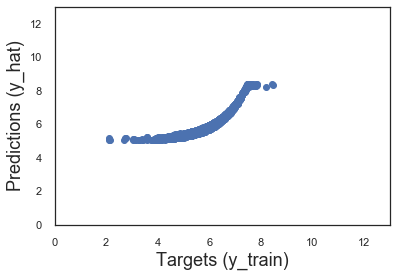

In [385]:
# The simplest way to compare the targets (y_train) and the predictions (y_hat) is to plot them on a scatter plot
# The closer the points to the 45-degree line, the better the prediction
plt.scatter(train_y, y_hat)
# Let's also name the axes
plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)
# Sometimes the plot will have different scales of the x-axis and the y-axis
# This is an issue as we won't be able to interpret the '45-degree line'
# We want the x-axis and the y-axis to be the same
plt.xlim(0,13)
plt.ylim(0,13)
plt.show()

In [386]:
reg.score(test_x,test_y)

0.8234425332633504

Text(0.5, 1.0, 'Residuals PDF')

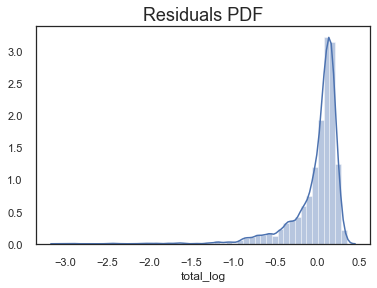

In [387]:
sns.distplot(train_y - y_hat)

# Include a title
plt.title("Residuals PDF", size=18)

In [388]:
y_hat_test = reg.predict(test_x)

In [389]:
test_x.shape

(999, 15)

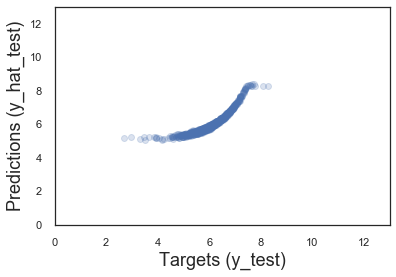

In [390]:
# Create a scatter plot with the test targets and the test predictions
# You can include the argument 'alpha' which will introduce opacity to the graph
plt.scatter(test_y, y_hat_test, alpha=0.2)
plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predictions (y_hat_test)',size=18)
plt.xlim(0,13)
plt.ylim(0,13)
plt.show()

In [391]:
df_pf = pd.DataFrame(np.exp(y_hat_test), columns=['Prediction'])
df_pf.head()

,Prediction
0,810.15
1,260.89
2,359.63
3,523.34
4,285.09


In [392]:
# We can also include the test targets in that data frame (so we can manually compare them)
df_pf['Target'] = np.exp(test_y)
df_pf

,Prediction,Target
0,810.15,nan
1,260.89,nan
2,359.63,359.97
3,523.34,359.41
4,285.09,nan
5,451.65,228.27
6,190.31,nan
7,1429.25,nan
8,808.74,467.83
9,632.17,nan


In [393]:
test_y = test_y.reset_index(drop=True)

In [394]:
test_y.head()

0   6.78
1   5.57
2   6.08
3   6.45
4   5.70
Name: total_log, dtype: float64

In [395]:
df_pf['Target'] = np.exp(test_y)
df_pf

,Prediction,Target
0,810.15,884.42
1,260.89,262.23
2,359.63,437.65
3,523.34,633.52
4,285.09,298.18
5,451.65,595.38
6,190.31,99.07
7,1429.25,1137.46
8,808.74,863.23
9,632.17,736.64


In [396]:
# Additionally, we can calculate the difference between the targets and the predictions
# Note that this is actually the residual (we already plotted the residuals)
df_pf['Residual'] = df_pf['Target'] - df_pf['Prediction']

In [397]:
df_pf['Difference%'] = np.absolute(df_pf['Residual']/df_pf['Target']*100)
df_pf

,Prediction,Target,Residual,Difference%
0,810.15,884.42,74.27,8.40
1,260.89,262.23,1.34,0.51
2,359.63,437.65,78.02,17.83
3,523.34,633.52,110.18,17.39
4,285.09,298.18,13.09,4.39
5,451.65,595.38,143.73,24.14
6,190.31,99.07,-91.24,92.09
7,1429.25,1137.46,-291.79,25.65
8,808.74,863.23,54.49,6.31
9,632.17,736.64,104.47,14.18


In [398]:
df_pf.describe()

,Prediction,Target,Residual,Difference%
count,999.00,999.00,999.00,999.00
mean,546.27,515.93,-30.34,22.95
std,601.44,369.86,301.36,57.03
min,155.05,14.51,-2381.89,0.00
25%,268.17,281.48,-20.80,8.11
50%,354.92,422.30,34.35,13.67
75%,548.73,639.24,74.03,19.17
max,4507.78,4019.51,164.31,1092.22


### Checking Linear Regression Model Accuracy

In [399]:
pd.options.display.max_rows = 999
# Moreover, to make the dataset clear, we can display the result with only 2 digits after the dot 
pd.set_option('display.float_format', lambda x: '%.2f' % x)
# Finally, we sort by difference in % and manually check the model
final_file=df_pf.sort_values(by=['Difference%'])

In [400]:
print('MSE Test:',metrics.mean_squared_error(test_y,y_hat_test))
print('MSE Train:',metrics.mean_squared_error(train_y,y_hat))

MSE Test: 0.07935168403266515
MSE Train: 0.08620136594830341


In [401]:
print ('MAE:', metrics.mean_absolute_error(test_y, y_hat_test))
print ('MSE:', metrics.mean_squared_error(test_y, y_hat_test))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(test_y, y_hat_test)))

MAE: 0.1851785120765592
MSE: 0.07935168403266515
RMSE: 0.28169430954966973


## Apply Random Forest

In [408]:
model = RandomForestRegressor(random_state=15, n_estimators=50,max_depth=5,n_jobs = 5)
model.fit(train_x, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=5,
                      oob_score=False, random_state=15, verbose=0,
                      warm_start=False)

In [409]:
model.score(test_x,test_y)

0.9929852159055844

In [406]:
pargrid_rf = {'n_estimators': [10,20,30,40,50,60,70, 80, 90, 100, 120,],
                  'max_features': [ 7, 8,9,10,11,12,13,14,15],
             'max_depth': [5,10,15,20,25,30]
             }

gscv_rf = GridSearchCV(estimator = RandomForestRegressor(), 
                        param_grid = pargrid_rf, 
                        cv = 5,
                        verbose = True, 
                        n_jobs = -1)

gscv_results = gscv_rf.fit(train_x, train_y)

Fitting 5 folds for each of 594 candidates, totalling 2970 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   52.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 2970 out of 2970 | elapsed: 13.6min finished


In [407]:
gscv_results.best_params_

{'max_depth': 5, 'max_features': 14, 'n_estimators': 50}

In [410]:
y_hat = model.predict(train_x)
y_hat

array([6.41017551, 5.61683166, 5.47325313, ..., 6.98066716, 5.45755872,
       5.72006088])

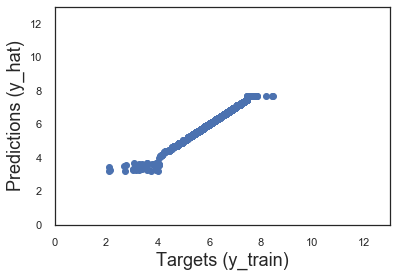

In [412]:
# The simplest way to compare the targets (y_train) and the predictions (y_hat) is to plot them on a scatter plot
# The closer the points to the 45-degree line, the better the prediction
plt.scatter(train_y, y_hat)
# Let's also name the axes
plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)
# Sometimes the plot will have different scales of the x-axis and the y-axis
# This is an issue as we won't be able to interpret the '45-degree line'
# We want the x-axis and the y-axis to be the same
plt.xlim(0,13)
plt.ylim(0,13)
plt.show()

Text(0.5, 1.0, 'Residuals PDF')

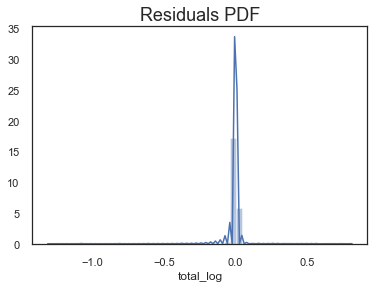

In [411]:
sns.distplot(train_y - y_hat)

# Include a title
plt.title("Residuals PDF", size=18)

In [413]:
y_hat_test = model.predict(test_x)

In [414]:
test_x.shape

(999, 15)

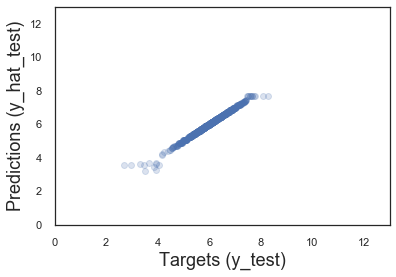

In [415]:
# Create a scatter plot with the test targets and the test predictions
# You can include the argument 'alpha' which will introduce opacity to the graph
plt.scatter(test_y, y_hat_test, alpha=0.2)
plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predictions (y_hat_test)',size=18)
plt.xlim(0,13)
plt.ylim(0,13)
plt.show()

In [416]:
df_pf = pd.DataFrame(np.exp(y_hat_test), columns=['Prediction'])
df_pf.head()

,Prediction
0,878.49
1,263.61
2,439.11
3,634.50
4,300.63


In [417]:
# We can also include the test targets in that data frame (so we can manually compare them)
df_pf['Target'] = np.exp(test_y)
df_pf

,Prediction,Target
0,878.49,884.42
1,263.61,262.23
2,439.11,437.65
3,634.50,633.52
4,300.63,298.18
5,595.47,595.38
6,103.03,99.07
7,1134.16,1137.46
8,852.19,863.23
9,742.57,736.64


In [418]:
# Additionally, we can calculate the difference between the targets and the predictions
# Note that this is actually the residual (we already plotted the residuals)
df_pf['Residual'] = df_pf['Target'] - df_pf['Prediction']


In [419]:
df_pf['Difference%'] = np.absolute(df_pf['Residual']/df_pf['Target']*100)
df_pf

,Prediction,Target,Residual,Difference%
0,878.49,884.42,5.93,0.67
1,263.61,262.23,-1.38,0.53
2,439.11,437.65,-1.46,0.33
3,634.50,633.52,-0.98,0.15
4,300.63,298.18,-2.45,0.82
5,595.47,595.38,-0.09,0.02
6,103.03,99.07,-3.96,4.00
7,1134.16,1137.46,3.30,0.29
8,852.19,863.23,11.04,1.28
9,742.57,736.64,-5.93,0.81


In [420]:
df_pf.describe()

,Prediction,Target,Residual,Difference%
count,999.00,999.00,999.00,999.00
mean,513.84,515.93,2.08,1.35
std,354.24,369.86,73.24,6.26
min,24.06,14.51,-440.58,0.00
25%,278.16,281.48,-1.50,0.21
50%,422.65,422.30,-0.08,0.44
75%,637.93,639.24,1.99,0.99
max,2212.59,4019.51,1887.99,140.77


In [421]:
pd.options.display.max_rows = 999
# Moreover, to make the dataset clear, we can display the result with only 2 digits after the dot 
pd.set_option('display.float_format', lambda x: '%.2f' % x)
# Finally, we sort by difference in % and manually check the model
final_file=df_pf.sort_values(by=['Difference%'])

### Checking Random Forest Model Accuracy

In [422]:
print('MSE Test:',metrics.mean_squared_error(test_y,y_hat_test))
print('MSE Train:',metrics.mean_squared_error(train_y,y_hat))

MSE Test: 0.003152712492458302
MSE Train: 0.0032743919165209674


In [423]:
print ('MAE:', metrics.mean_absolute_error(test_y, y_hat_test))
print ('MSE:', metrics.mean_squared_error(test_y, y_hat_test))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(test_y, y_hat_test)))

MAE: 0.013320362552311336
MSE: 0.003152712492458302
RMSE: 0.05614902040515312


In [424]:
%cd C:\\Users\\acer\\Desktop\\Pandas CAse
final_file.to_csv('Test_results.csv',index=False)

C:\Users\acer\Desktop\Pandas CAse
